### Initial Variable Definations

In [149]:
%pylab inline
%matplotlib
#%%writefile ../crypto_chaotic/audioClient.py
#!/usr/bin/env python

import pyaudio
import wave
from twisted.internet.protocol import DatagramProtocol
from twisted.internet import reactor
import numpy as np
from crypto_chaotic.modulation import drawfft
from matplotlib import rcParams
import matplotlib.pyplot as plt
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
#from scipy.fftpack import rfft, irfft, fftfreq

CHUNK = 44100*5
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
#RECORD_SECONDS = 60*60

tstep = 0.001 #0.0001
ndrop = 1500 #15000
N = 4

Amplification = 100000 #500000


def drawfft(signals, d=1, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), d=d)

        Nindex = np.argmax(freq < 0)
        #freq1 = np.append(freq[Nindex:], freq[:Nindex])
        #sp1 = np.append(sp[Nindex:], sp[:Nindex])
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()
    

Populating the interactive namespace from numpy and matplotlib
Using matplotlib backend: Qt5Agg


### Voice Capture and preprocessing at Transmitter

In [150]:
p = pyaudio.PyAudio()

inputStream = p.open(format=FORMAT,
                     channels=CHANNELS,
                     rate=RATE,
                     input=True,
                     frames_per_buffer=CHUNK)

voicestream = inputStream.read(CHUNK)
inputStream.close()

#########################################
###     Voice Data                    ###
#########################################
modsig = np.fromstring(voicestream, dtype=np.int16)

#########################################
###         Frequency Domain          ###
#########################################
d=(1.0 * CHUNK)/RATE
#W = fftfreq(modsig.size, d=d)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
minm = 100*d
maxm = 18000*d
cut_f_signal = f_signal.copy()
for j in range(len(cut_f_signal)):
    if j < minm:
        cut_f_signal[j] = 0
    elif j > maxm:
        cut_f_signal[j] = 0

#########################################
###            Time Domain            ###
#########################################
tcut_signal0 = irfft(cut_f_signal)

### Chaos Encryption at Transmitter

Populating the interactive namespace from numpy and matplotlib
0 -1


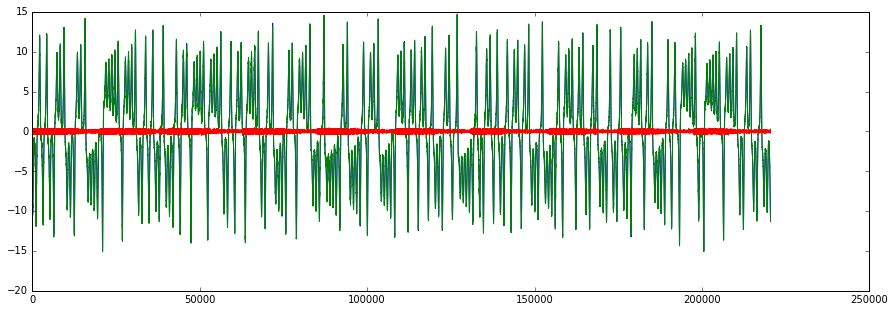

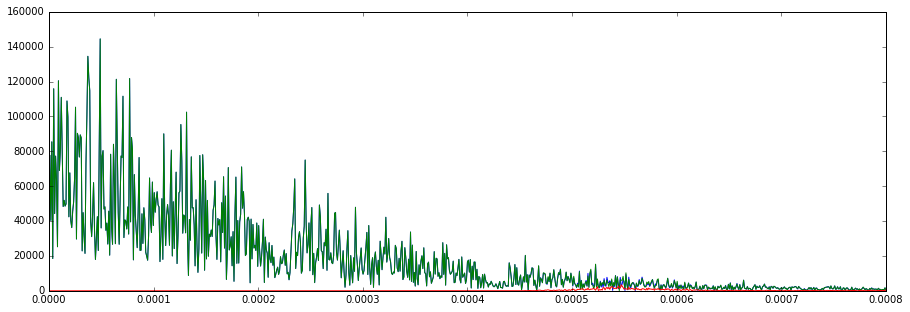

In [151]:
%pylab inline
#########################################
###     Time Domain Amplification     ###
#########################################
cut_signal = np.array(tcut_signal0/Amplification, dtype=np.float64)

#########################################
###           Chaos Encrypt           ###
#########################################
encryptedx, xt = lorenz_attractor.chaos_encrypt(cut_signal, 
                                                N = N, tstep = tstep, ndrop = ndrop)

modulation.plotamp([xt, encryptedx, cut_signal], xmin = 0, xmax = 0)
drawfft([xt, encryptedx, cut_signal], d=d, xlow=0, xhigh=0.0008, ylow=0, yhigh=0)

### Chaos Decryption at Reciever

0 -1


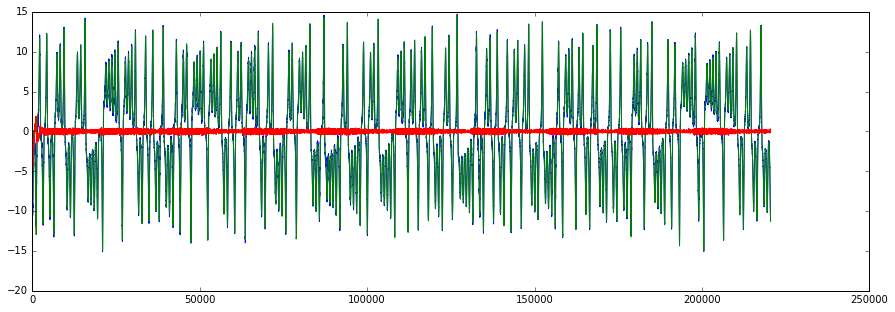

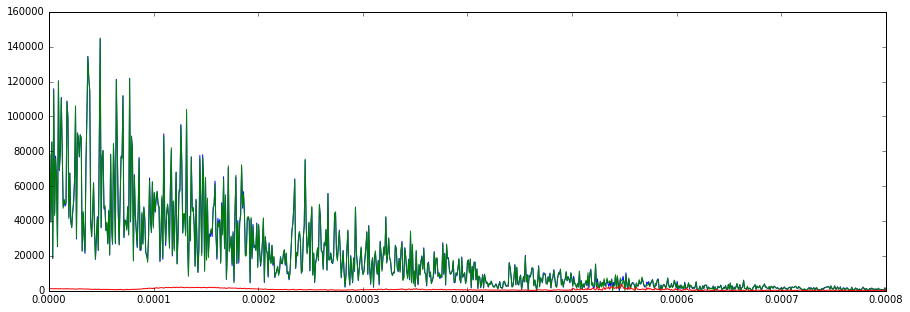

In [152]:
#########################################
###           Chaos Encrypt           ###
#########################################
recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx, 
                                               N = N, tstep = tstep, ndrop = ndrop)

#########################################
###     Time Domain Amplification     ###
#########################################
recovered_amp = recovered * Amplification

modulation.plotamp([encryptedx, xr, recovered], xmin = 0, xmax = 0)
drawfft([encryptedx, xr, recovered], d, xlow=0, xhigh=0.0008, ylow=0, yhigh=0)


### Post Processing and Regeneration of Voice at Reciever

In [172]:
#########################################
###            Time Domain            ###
#########################################
recovered_buff = np.array(recovered_amp.astype(int), dtype=np.int16)

#########################################
###         Frequency Domain          ###
#########################################
d=(1.0 * CHUNK)/RATE
f_signal = rfft(recovered_buff[5000:])

#########################################
###              Filter               ###
#########################################
minm = 10*d
maxm = 10000*d
cut_f_signal = f_signal.copy()
for j in range(len(cut_f_signal)):
    if j < minm:
        cut_f_signal[j] = 0
    elif j > maxm:
        cut_f_signal[j] = 0

#########################################
###             Time Domain           ###
#########################################
rcut_signal0 = irfft(cut_f_signal)
cut_signal = np.array(rcut_signal0.astype(int), dtype=np.int16)

outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)

outputStream.write(cut_signal.tostring())
outputStream.close()

In [174]:
outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)
outputStream.write(voicestream)
outputStream.close()